# Question 2

In [ ]:
#imports
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re
import nltk
imort matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
final = pd.read_csv('senti.csv')

In [168]:
# Add custom stop words specific to the domain
ENGLISH_STOP_WORDS = set(stopwords.words('english'))
custom_stop_words = set(ENGLISH_STOP_WORDS).union({'really', 'just', 'umm', 'need', 'appreciate', 'United Airlines', 'let', 'youre', 'typing noise', 'im','calling'})

# Function to clean and remove stop words from customer dialogues
def clean_customer_dialogue(dialogue):
    if isinstance(dialogue, str):
        # Remove non-alphanumeric characters (keeping basic punctuation)
        dialogue = re.sub(r'[^A-Za-z0-9\s.,?!]', '', dialogue)
        # Remove extra whitespace
        dialogue = re.sub(r'\s+', ' ', dialogue).strip()
        # Convert to lowercase for uniformity
        dialogue = dialogue.lower()
        # Tokenize and remove stop words
        words = dialogue.split()
        cleaned_words = [word for word in words if word not in custom_stop_words]
        # Join words back to form cleaned dialogue
        cleaned_dialogue = ' '.join(cleaned_words)
        return cleaned_dialogue
    return dialogue

# Apply the cleaning function to the 'customer_dialogues' column
final['cleaned_customer_dialogues'] = final['cleaned_customer_dialogues'].apply(clean_customer_dialogue)

Top recurring issues based on keywords: [('change', 103493), ('chicago', 58190), ('time', 57804), ('help', 52732), ('day', 50266), ('booked', 47470), ('way', 44237), ('better', 43721), ('work', 43687), ('thats', 42193)]


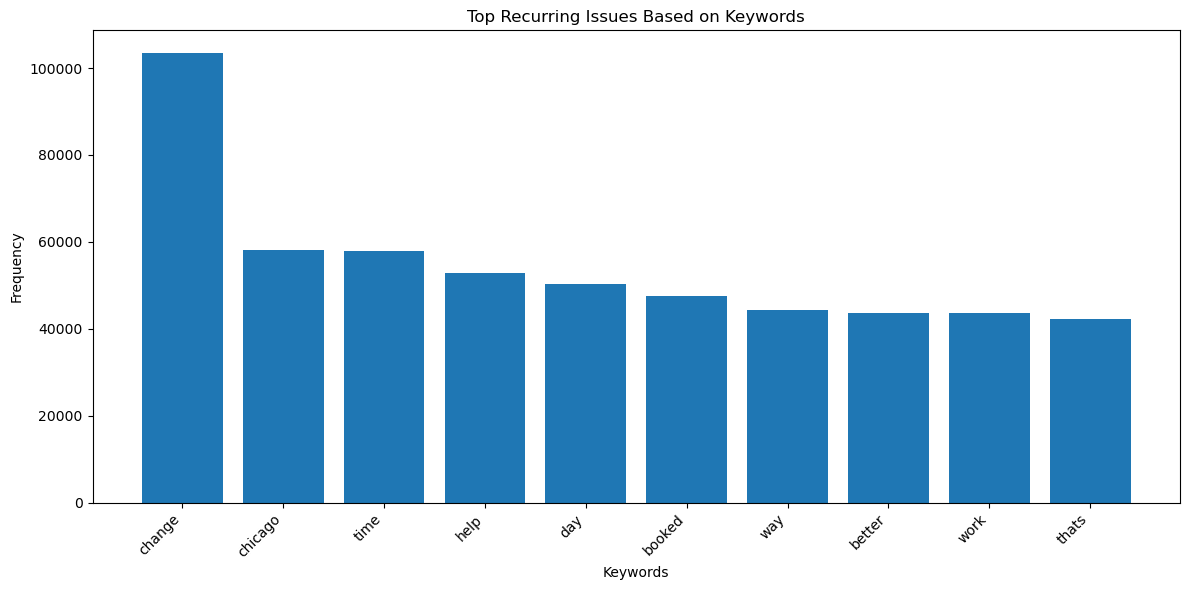

In [172]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to extract top keywords from a list of texts
def extract_keywords(texts, num_keywords=10):
    vectorizer = CountVectorizer(max_df=0.8, stop_words='english', max_features=10000)
    X = vectorizer.fit_transform(texts)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:num_keywords]

# Extract top keywords from call transcripts to identify recurring issues
top_keywords = extract_keywords(final['cleaned_customer_dialogues'])
print("Top recurring issues based on keywords:", top_keywords)

# Create a bar plot of top keywords
plt.figure(figsize=(12, 6))
keywords, frequencies = zip(*top_keywords)
plt.bar(keywords, frequencies)
plt.title('Top Recurring Issues Based on Keywords')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [170]:
from sklearn.decomposition import LatentDirichation
from sklearn.feature_extraction.text import TfidfVectoletAllocrizer
from sklearn.decomposition import LatentDirichletAllocation

# Use TF-IDF Vectorizer to create document-term matrix for topic modeling
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(final['cleaned_customer_dialogues'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # n_components: number of topics
lda.fit(tfidf_matrix)

# Display top words per topic
def display_topics(model, feature_names, num_words=5):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}: ", " ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(lda, tfidf_feature_names)

Topic 0:  change yeah fee thank day
Topic 1:  guess hours delayed yeah guys
Topic 2:  seat wanted check double upgrade
Topic 3:  earlier yeah meeting time thanks
Topic 4:  check wanted double time schedule


In [144]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 3.9 MB/s eta 0:00:00a 0:00:01


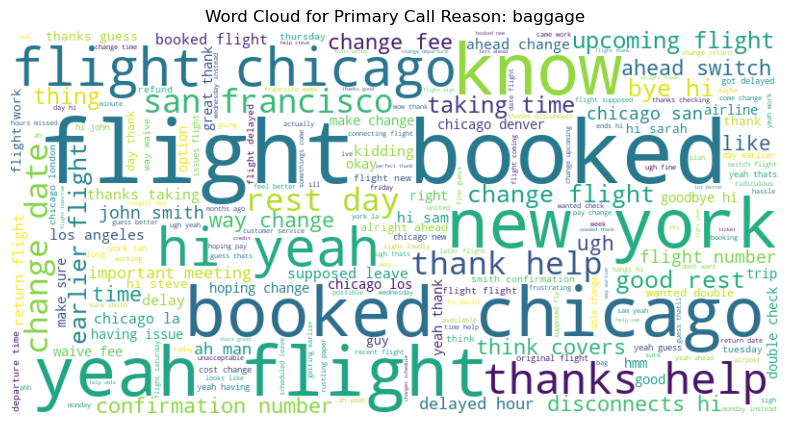

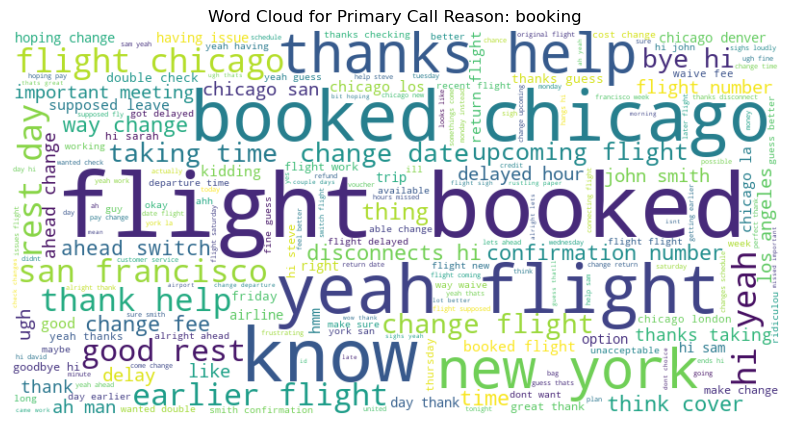

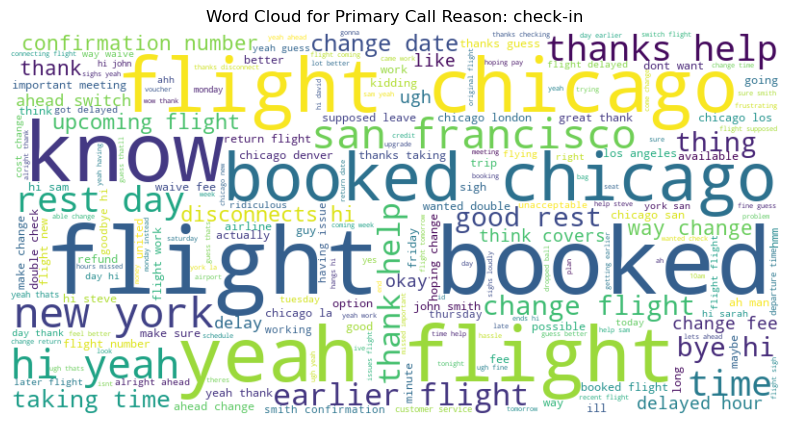

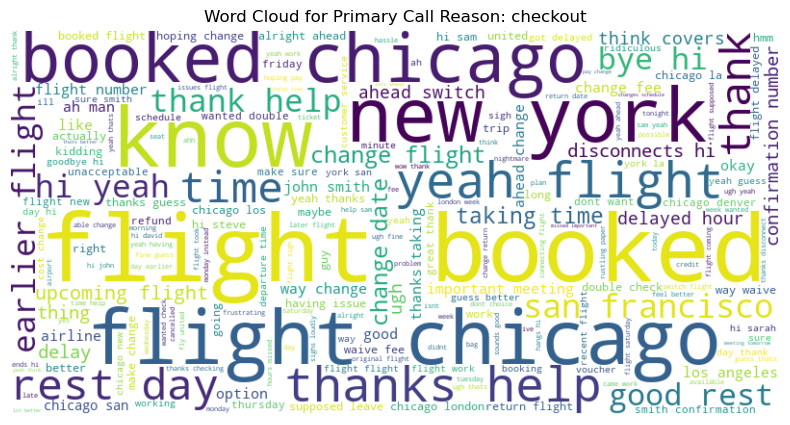

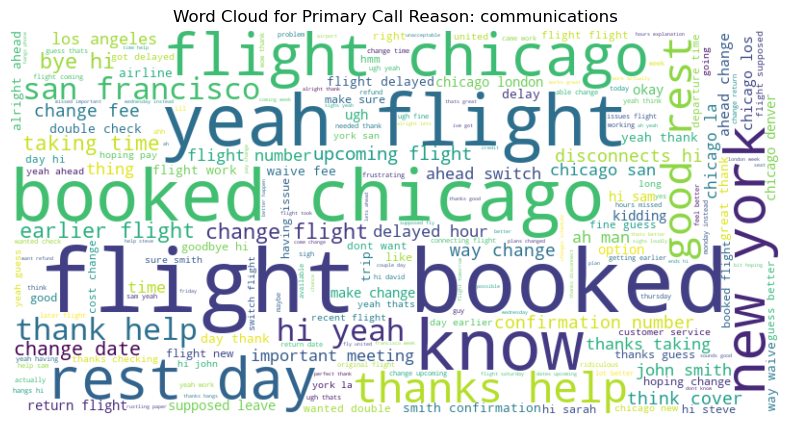

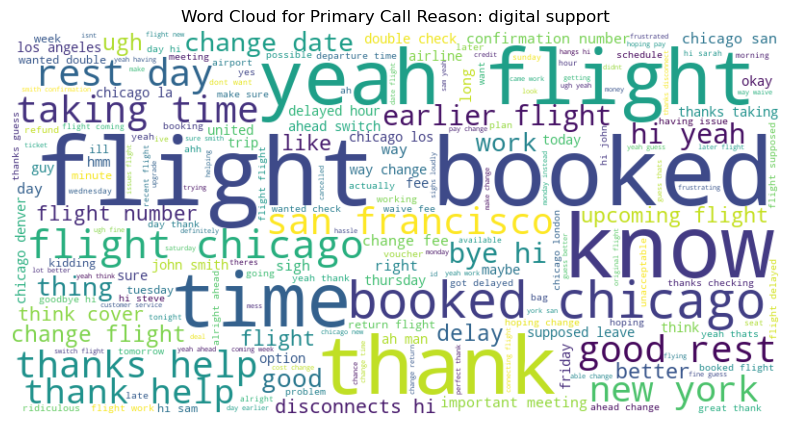

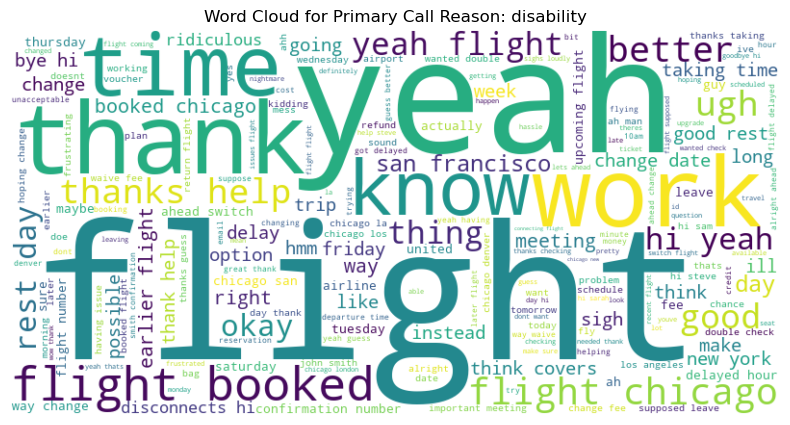

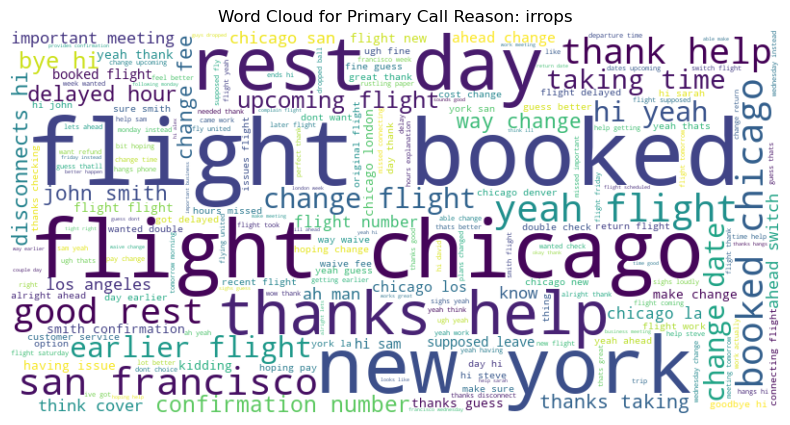

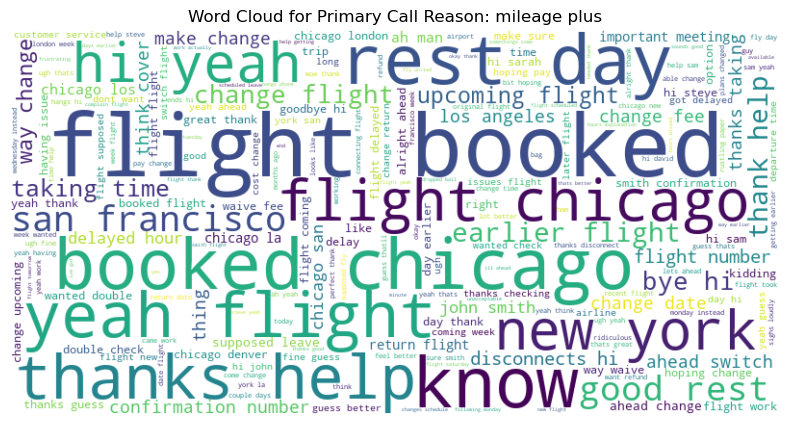

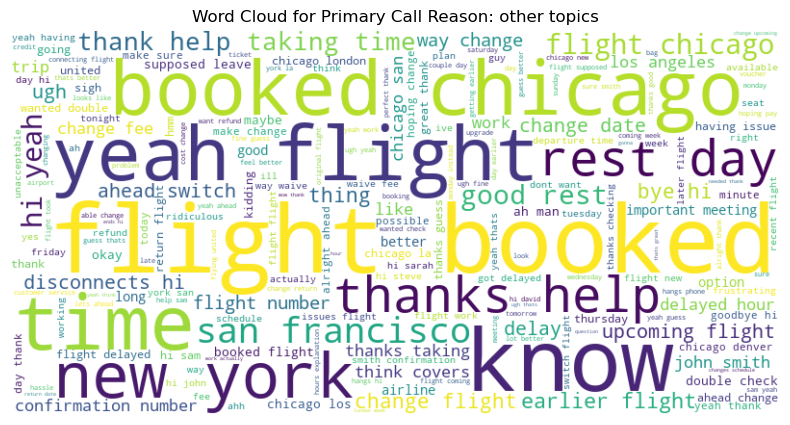

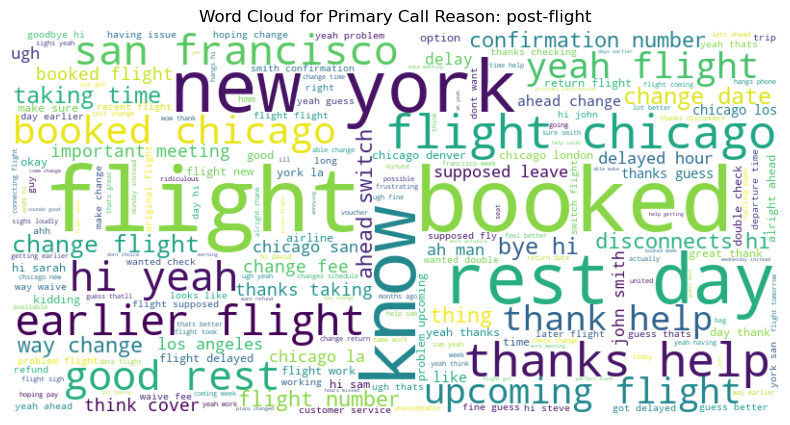

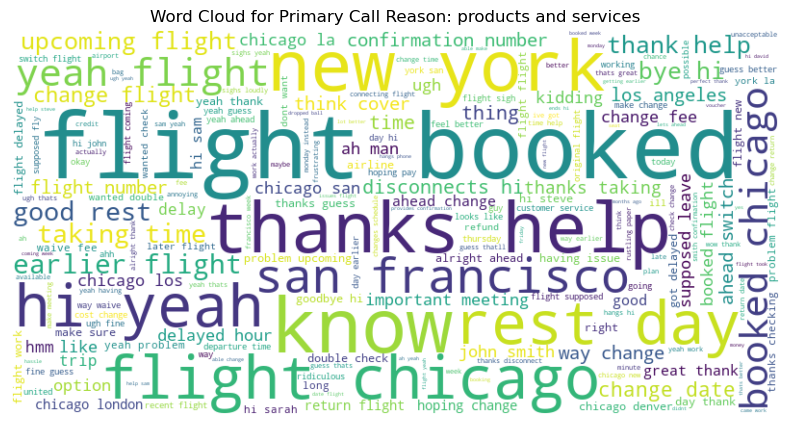

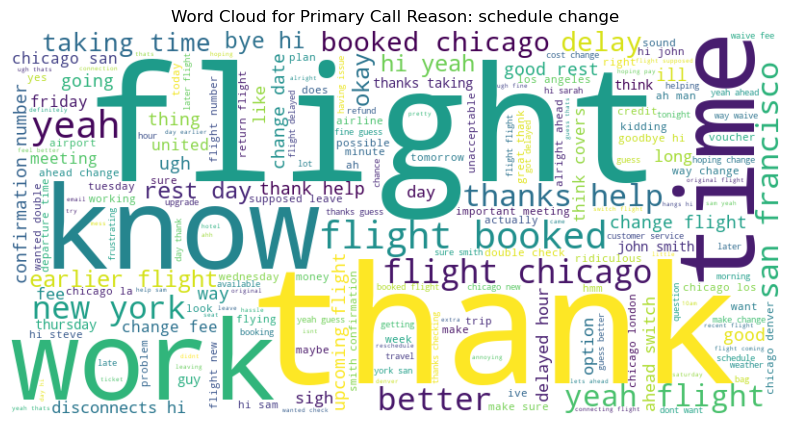

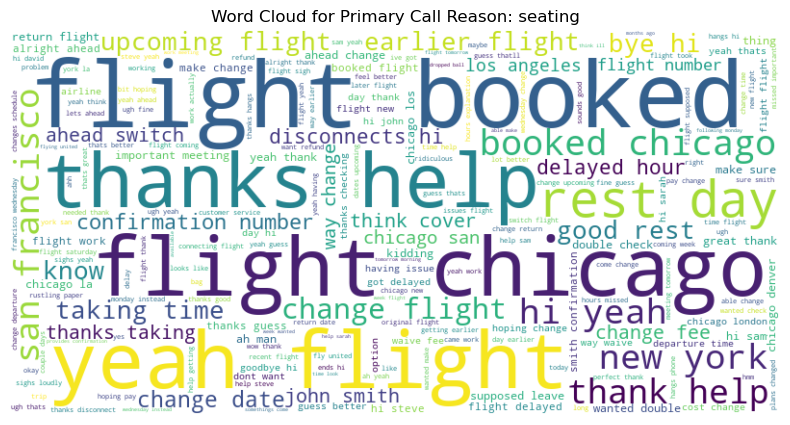

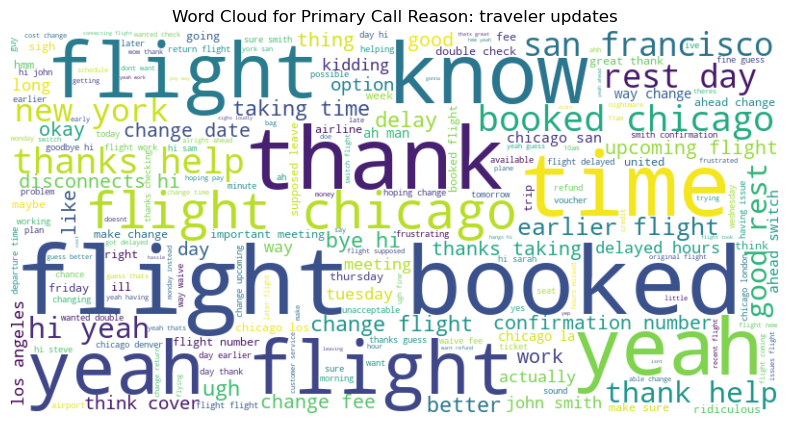

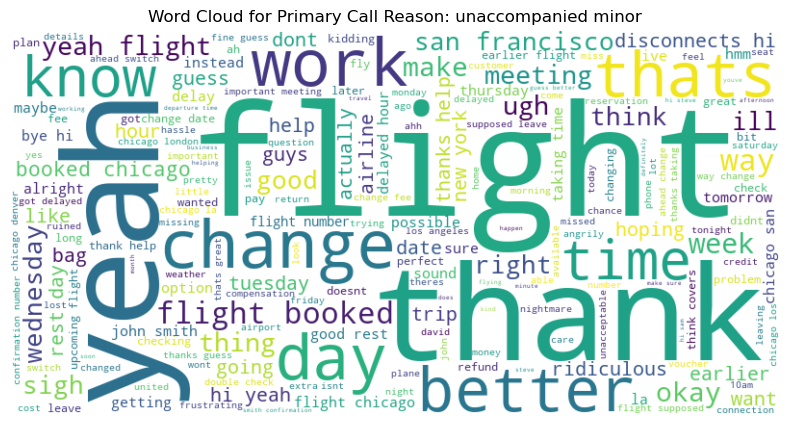

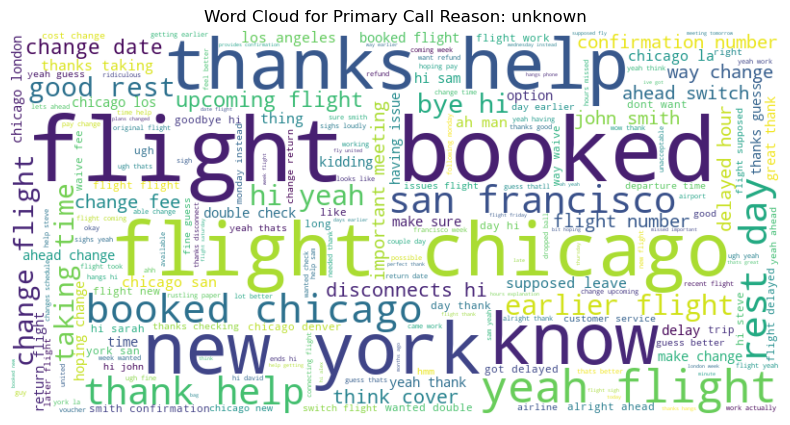

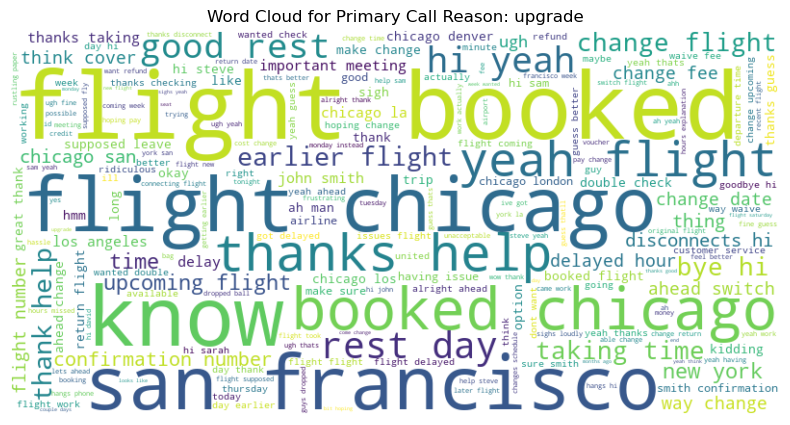

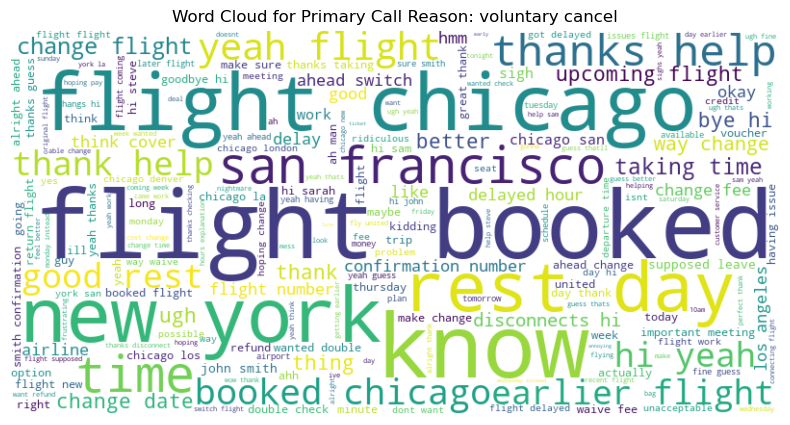

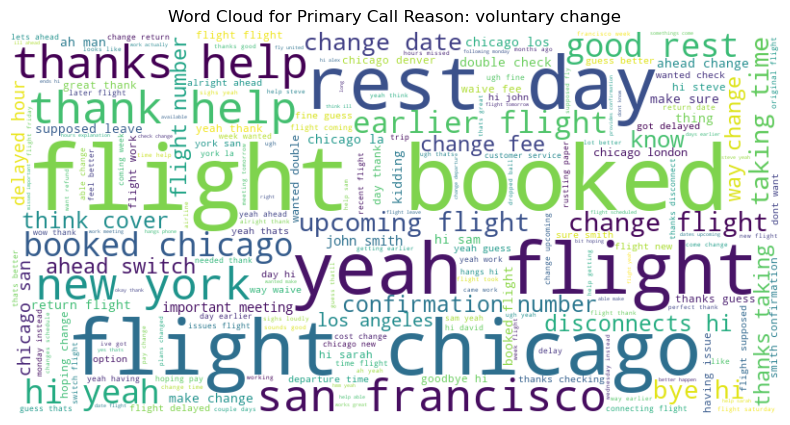

In [171]:
from wordcloud import WordCloud
# Group cleaned transcripts by primary_call_reason
grouped_transcripts = final.groupby('primary_call_reason_cleaned')['cleaned_customer_dialogues'].apply(lambda x: ' '.join(x))

# Create word clouds for each primary call reason
for reason, text in grouped_transcripts.items():
    # Generate a word cloud for the current reason
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stop_words).generate(text)
    
    # Plotting the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Primary Call Reason: {reason}")
    plt.show()  

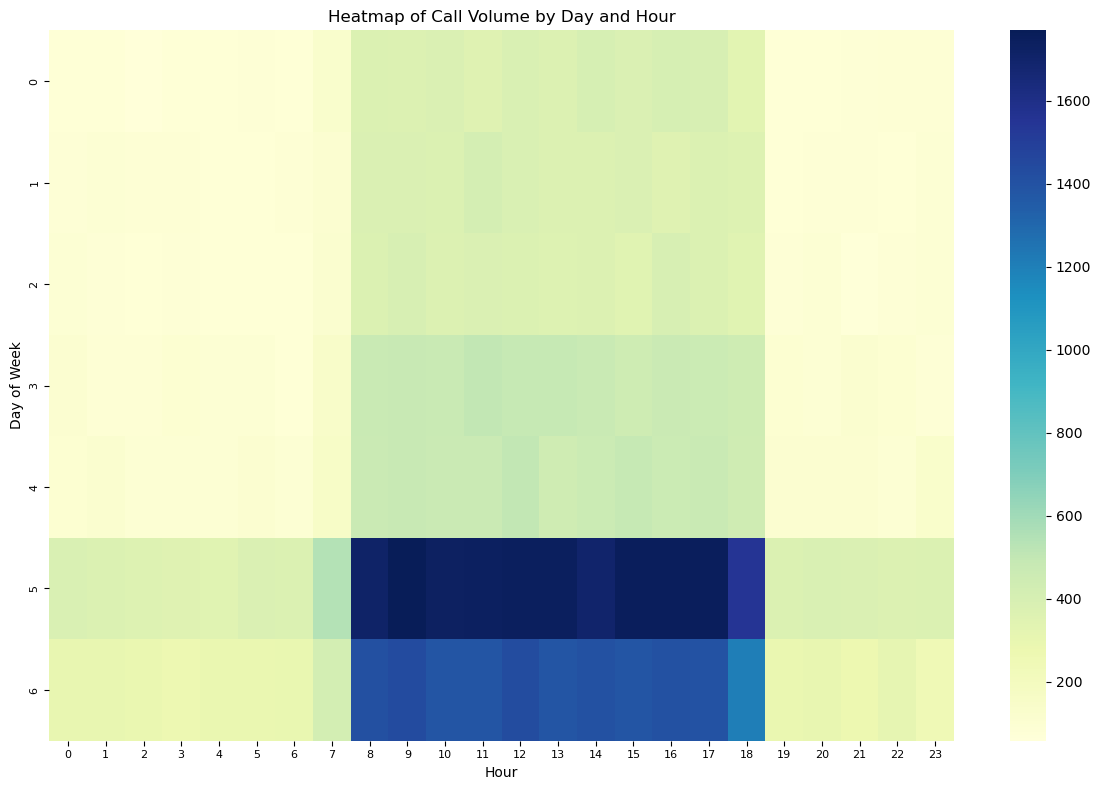

In [142]:
# Heatmap of Call Volume by Day and Hour
call_volume = final.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(call_volume, annot=False, cmap="YlGnBu")
plt.title('Heatmap of Call Volume by Day and Hour', fontsize=12)
plt.xlabel('Hour')
plt.ylabel('Day of Week')
plt.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

In [173]:
# Use TF-IDF to transform the cleaned transcript data
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(final['cleaned_transcript'].dropna())

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display top words per topic
def display_topics(model, feature_names, num_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}: ", " | ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))

feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names)

Topic 1:  flight | change | agent | customer | fee | let | help | date | work | need
Topic 2:  flight | agent | customer | tomorrow | let | sir | meeting | like | delay | frustration
Topic 3:  seat | agent | standby | flight | customer | bag | upgrade | check | list | waitlist
Topic 4:  customer | agent | flight | delay | voucher | refund | experience | delays | united | delayed
Topic 5:  flight | agent | customer | weather | forecast | wanted | time | check | help | just


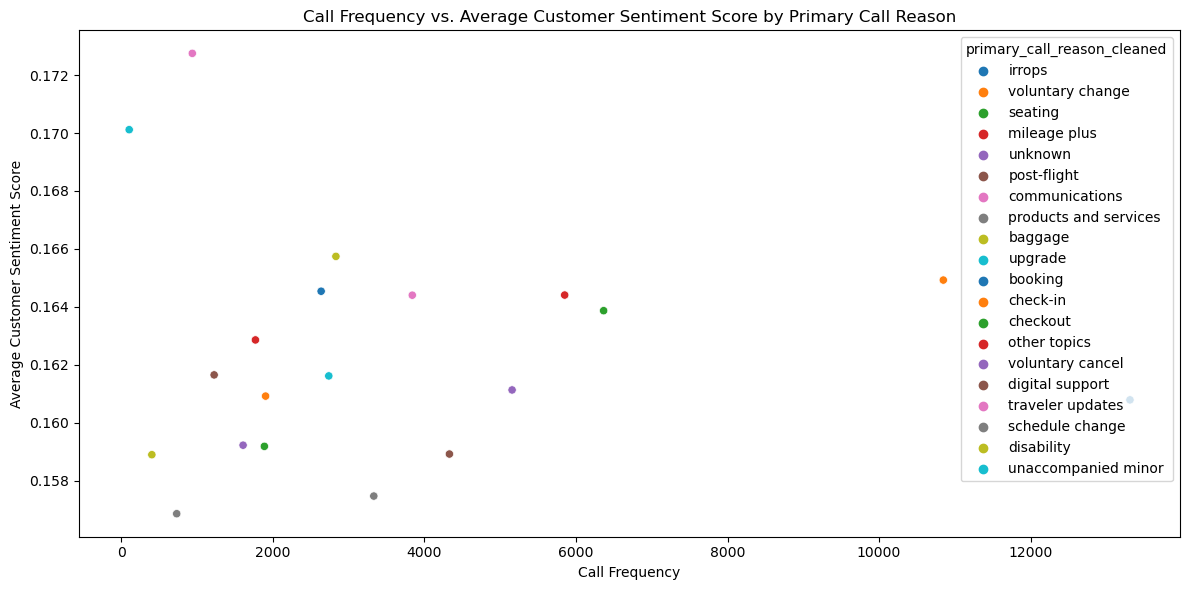

In [179]:
# Analyze call frequency vs sentiment scores
avg_sentiment = final.groupby('primary_call_reason_cleaned')['customer_sentiment_score'].mean().reset_index()
call_counts = final['primary_call_reason_cleaned'].value_counts().reset_index()
call_counts.columns = ['primary_call_reason_cleaned', 'count']

sentiment_vs_frequency = pd.merge(call_counts, avg_sentiment, on='primary_call_reason_cleaned')

# Plotting call frequency vs sentiment
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sentiment_vs_frequency, x='count', y='customer_sentiment_score', hue='primary_call_reason_cleaned', palette='tab10')
plt.title('Call Frequency vs. Average Customer Sentiment Score by Primary Call Reason')
plt.xlabel('Call Frequency')
plt.ylabel('Average Customer Sentiment Score')
plt.tight_layout()
plt.show()